In [1]:
import pandas as pd
import numpy as np
import os
from dotenv import dotenv_values, find_dotenv

import preparecorrelations as pc

In [2]:
# this looks for your configuration file and then reads it as a dictionary
config = dotenv_values(find_dotenv())

In [3]:
# set path using the dictionary key for which one you want
correlationpath = os.path.abspath(config["CORRELATIONDATA"]) + '\\'
cleandatapath = os.path.abspath(config["CLEANDATA"]) + '\\'

In [4]:
xlsx = pd.ExcelFile(correlationpath + "gdp_consumption_haver_final.xlsx")
rgdp = pd.read_excel(xlsx, 'Real GDP')
rc = pd.read_excel(xlsx, 'Real C')

In [5]:
oecd_countries = ["Australia", "Austria", "Belgium", "Canada", "Denmark", "Finland", "France", "Germany", "Greece", "Iceland", "Ireland", 
                  "Italy", "Japan", "Luxembourg", "Netherlands", "Norway", "Portugal", "Spain", "Sweden", "Switzerland", 
                  "Turkey", "U.K.", "U.S."] 

MSCI_EM_countries = ["Brazil", "Chile", "China", "Colombia", "Czech Republic", "Egypt", "Greece", "Hungary", "India", 
                     "Indonesia", "South Korea", "Kuwait", "Malaysia", "Mexico", "Peru", "Philippines", "Poland", "Qatar", 
                     "Saudi Arabia", "South Africa", "Taiwan", "Thailand", "Turkey", "United Arab Emirates"]

total_columns = ['date'] + oecd_countries + MSCI_EM_countries

In [6]:
test = pc.SeasonalAdjustment(pc.fixCols(rgdp, total_columns))

c:\Users\fuem\.conda\envs\myenv\Lib\site-packages\statsmodels\tsa\x13.py:189: X13Warning: NOTE: Unable to test LS2020.2 due to regression matrix singularity.
       The effect of this outlier is already accounted for by other regressors 
       (usually user-specified or previously identified outliers).

 NOTE: Unable to test LS2020.3 due to regression matrix singularity.
       The effect of this outlier is already accounted for by other regressors 
       (usually user-specified or previously identified outliers).

          so the standard errors and the correlation matrix of the ARMA
          parameters will not be printed out.


 NOTE: Unable to test LS2008.4 due to regression matrix singularity.
       The effect of this outlier is already accounted for by other regressors 
       (usually user-specified or previously identified outliers).

 NOTE: Unable to test LS2020.2 due to regression matrix singularity.
       The effect of this outlier is already accounted for by other reg

In [7]:
# some countries we wanted to remove
to_remove = ['EGY', 'SAU', 'MYS', 'COL', 'QAT', 'KWT', 'CHN']

# defines the final list of stuff to include
final_columns = list(set(list(test.columns)) - set(to_remove))

In [8]:
myobject = pc.Prepare_Correlations(test, detrending="first difference", countries=final_columns)

In [9]:
myobject = myobject.detrend(start_date="1998-01-01", end_date="2021-12-31")

In [10]:
myobject.data

,AUS,AUT,BEL,CAN,DNK,FIN,FRA,DEU,GRC,ISL,...,IDN,KOR,MEX,PER,PHL,POL,ZAF,TWN,THA,TUR
date,,,,,,,,,,,,,,,,,,,,,
1998-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-01,0.010897,0.009217,0.001553,0.003201,-0.009860,0.021473,0.008052,-0.004143,0.004437,0.101955,...,-0.079196,-0.007818,0.008621,-0.024152,-0.015643,-0.002854,0.001316,0.006442,-0.036612,-0.034673
1998-07-01,0.018060,0.005528,0.002891,0.008710,0.019876,0.012910,0.007376,0.004811,0.002538,0.007224,...,-0.019186,0.016659,0.004503,0.035758,-0.004372,0.007967,-0.001555,0.023603,0.008250,-0.022898
1998-10-01,0.011198,0.005207,0.003350,0.014128,0.004179,0.009909,0.007098,-0.002717,0.008066,0.018096,...,-0.018174,0.024927,0.002495,-0.013427,0.007258,0.008233,0.001670,0.002185,0.042235,0.034877
1999-01-01,0.010320,0.007335,0.010767,0.014912,0.008587,0.013451,0.006076,0.009010,0.008038,0.000609,...,0.048134,0.030048,0.008598,-0.001165,0.017948,0.002676,0.008231,0.027823,-0.004823,-0.046532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,0.033076,-0.017661,-0.001898,0.021383,0.001469,0.010107,-0.009833,0.007795,0.039259,0.027359,...,0.022805,0.010499,0.037818,0.043023,0.029098,-0.002415,0.024895,0.012887,0.002807,0.013395
2021-01-01,0.017696,-0.005689,0.012325,0.012062,0.002734,-0.003825,0.001840,-0.014697,0.042898,0.012716,...,0.012539,0.017368,0.004916,0.024846,0.013527,0.013923,0.010443,0.034148,0.001752,0.024998
2021-04-01,0.006752,0.040345,0.017189,-0.008429,0.019866,0.018205,0.011709,0.021088,0.009253,0.025690,...,0.003410,0.008098,0.010579,0.006411,-0.001547,0.018925,0.012618,-0.008408,0.000431,-0.025999


In [11]:
mycorrelationmatrix = myobject.get_correlationmatrix()

In [12]:
mycorrelationmatrix

,USA,BEL,GBR,CAN,ESP,HUN,ZAF,FRA,ITA,MEX,...,FIN,TUR,THA,LUX,KOR,NOR,IDN,ISL,IRL,TWN
USA,1.000000,0.933405,0.932496,0.926048,0.922537,0.911740,0.904426,0.901517,0.900846,0.900649,...,0.689592,0.675377,0.628459,0.571143,0.539359,0.529875,0.484600,0.390054,0.365958,0.310694
BEL,0.933405,1.000000,0.955544,0.923567,0.964888,0.911132,0.919142,0.969517,0.972455,0.901712,...,0.674684,0.737587,0.631912,0.634308,0.536545,0.598686,0.510629,0.374397,0.363396,0.271939
GBR,0.932496,0.955544,1.000000,0.912081,0.960744,0.928312,0.947373,0.935985,0.938334,0.929697,...,0.672955,0.706687,0.624558,0.584111,0.456017,0.567628,0.496120,0.423407,0.321580,0.191651
CAN,0.926048,0.923567,0.912081,1.000000,0.932629,0.897293,0.927480,0.909660,0.897541,0.930212,...,0.695389,0.699522,0.636091,0.609313,0.550144,0.572539,0.539658,0.396741,0.276061,0.259517
ESP,0.922537,0.964888,0.960744,0.932629,1.000000,0.923413,0.921758,0.964877,0.965879,0.905817,...,0.704251,0.703357,0.625662,0.615116,0.492239,0.589335,0.484488,0.429538,0.340316,0.196258
HUN,0.911740,0.911132,0.928312,0.897293,0.923413,1.000000,0.910307,0.875447,0.899274,0.895182,...,0.699285,0.705471,0.551430,0.565635,0.466812,0.522498,0.476352,0.419281,0.385912,0.203207
ZAF,0.904426,0.919142,0.947373,0.927480,0.921758,0.910307,1.000000,0.881837,0.876455,0.943364,...,0.652715,0.695677,0.633672,0.566411,0.477534,0.548293,0.574836,0.412332,0.305593,0.195388
FRA,0.901517,0.969517,0.935985,0.909660,0.964877,0.875447,0.881837,1.000000,0.981479,0.866634,...,0.659860,0.735031,0.605995,0.606424,0.452944,0.587725,0.434459,0.359815,0.349571,0.244836
ITA,0.900846,0.972455,0.938334,0.897541,0.965879,0.899274,0.876455,0.981479,1.000000,0.868528,...,0.692363,0.731182,0.601192,0.617105,0.480479,0.574580,0.454627,0.382318,0.360629,0.268645
MEX,0.900649,0.901712,0.929697,0.930212,0.905817,0.895182,0.943364,0.866634,0.868528,1.000000,...,0.717406,0.705591,0.642417,0.586763,0.479578,0.564489,0.536174,0.470533,0.300231,0.203551


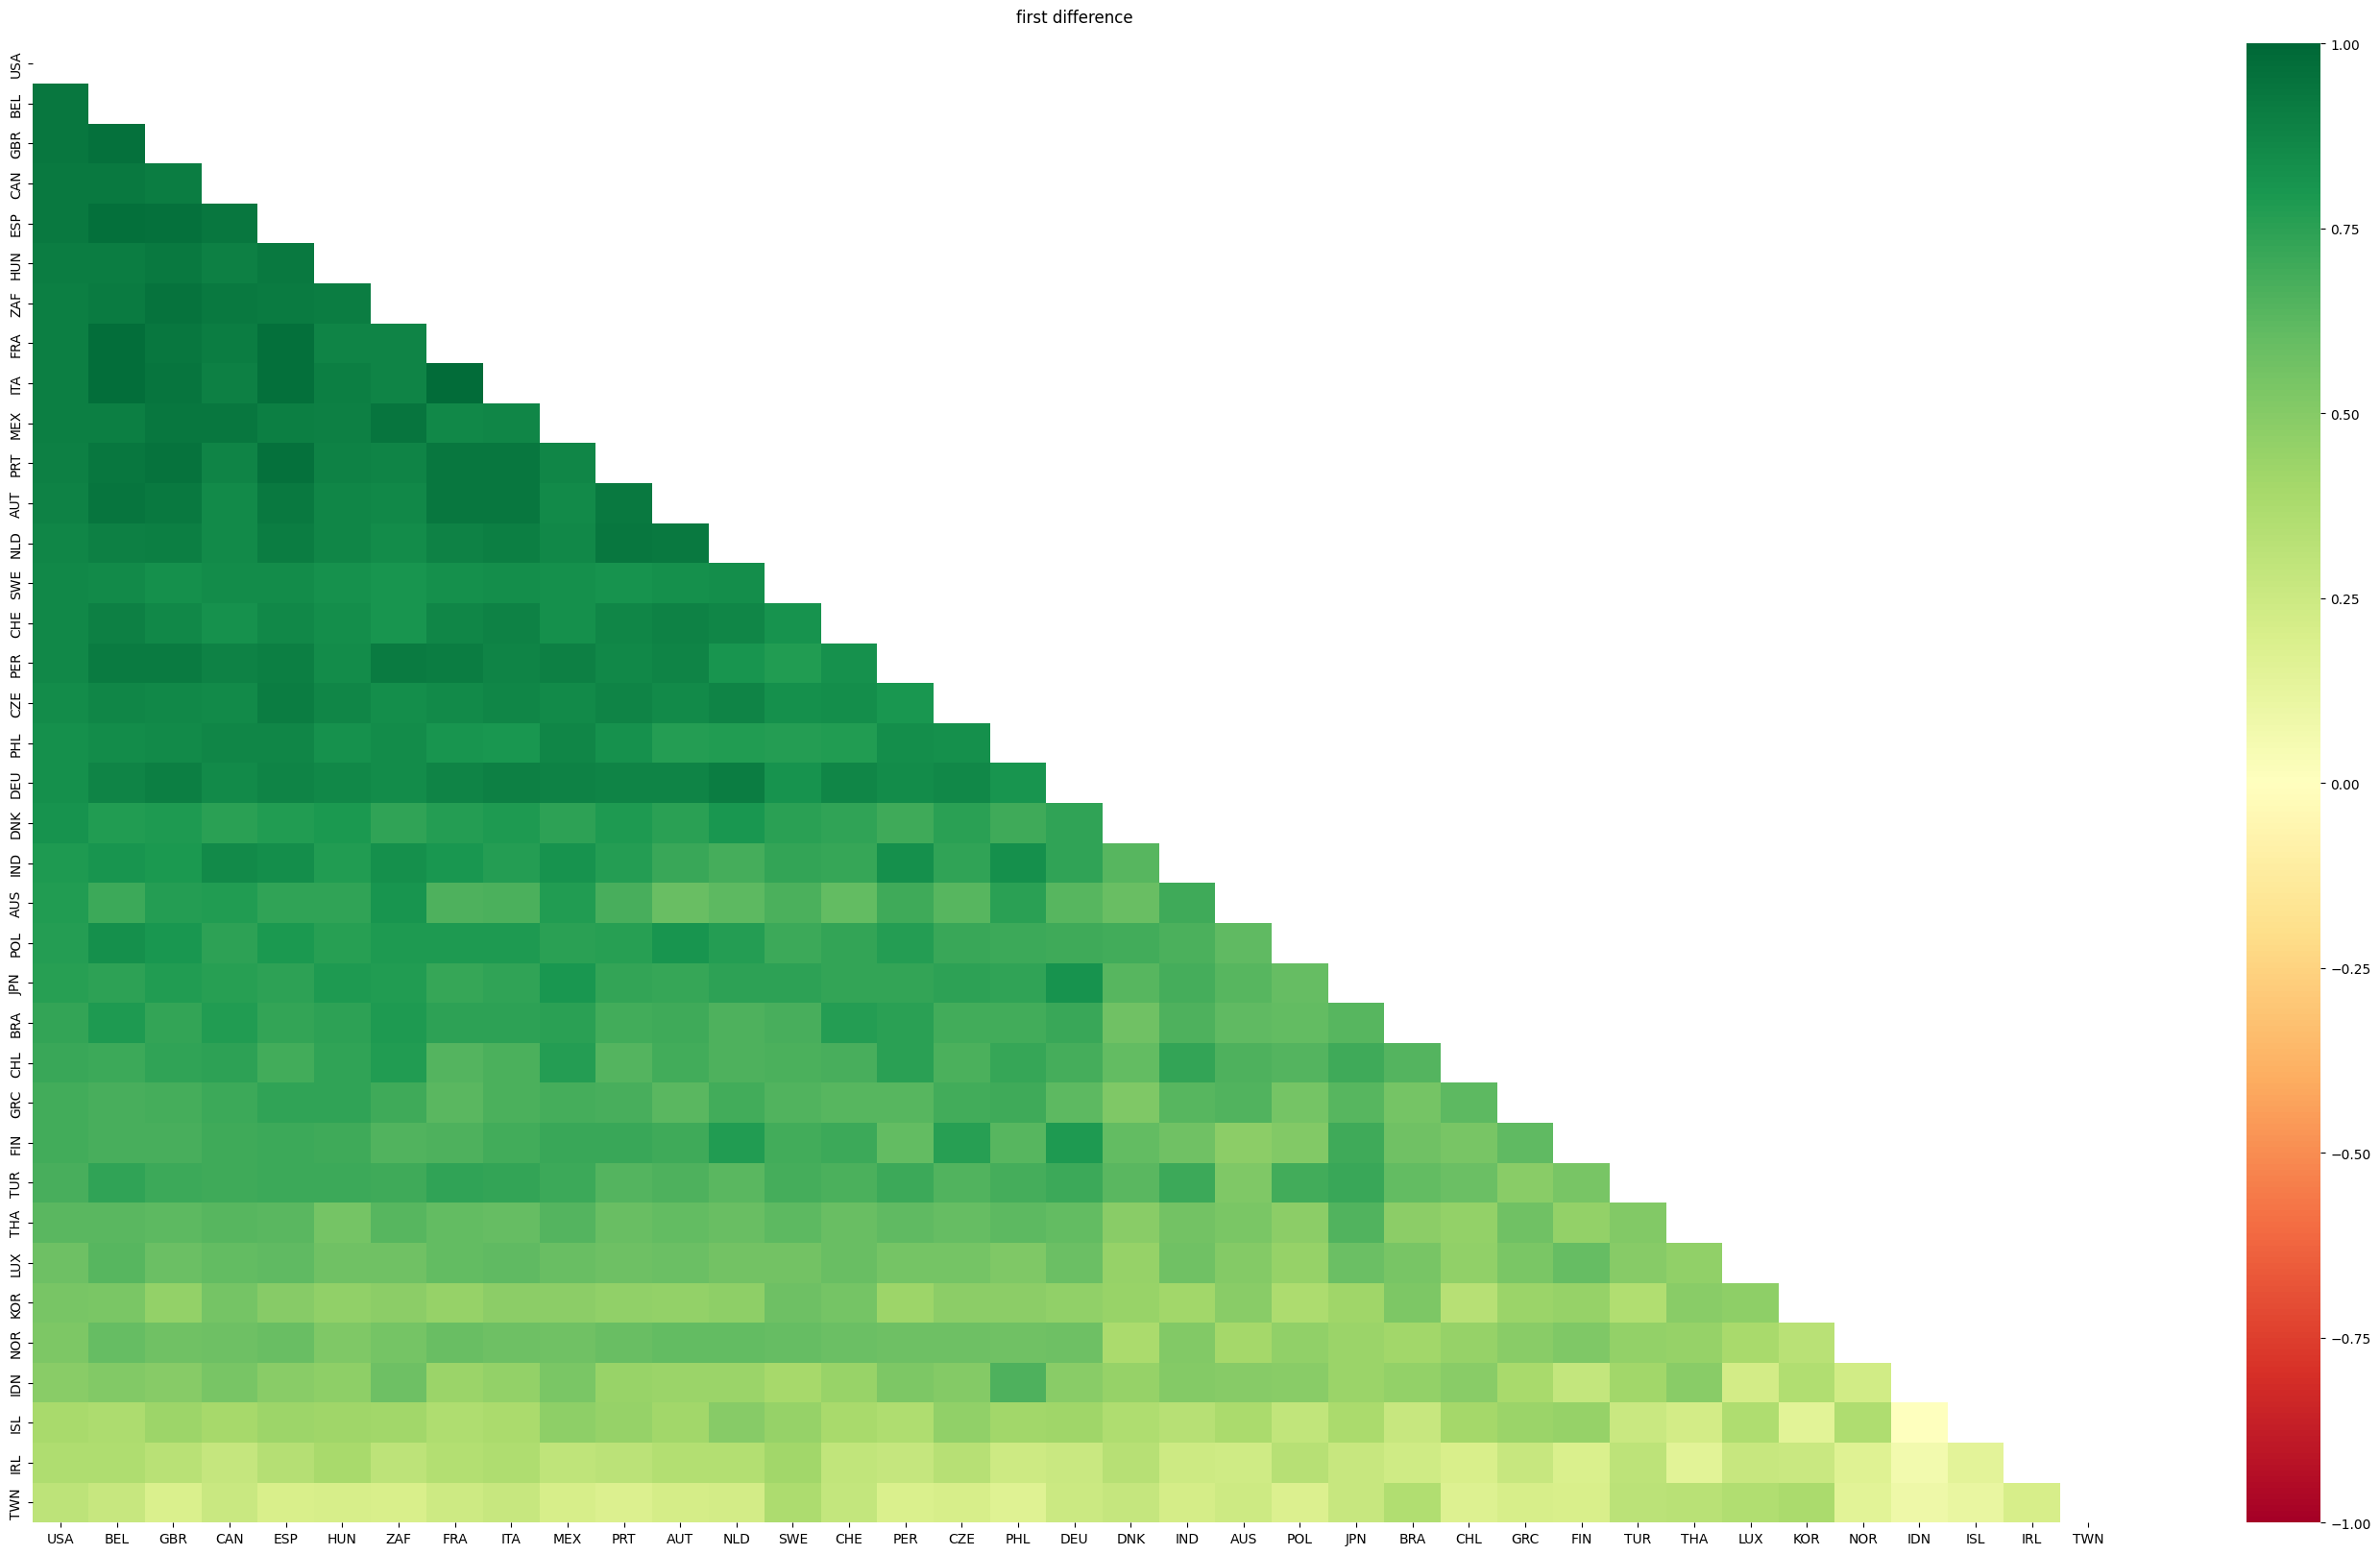

In [13]:
myheatmap = myobject.get_heatmap()

In [14]:
myreshapeddata = myobject.get_organized()

In [15]:
myreshapeddata

,iso3_firstcountry,iso3_secondcountry,correlation
1,USA,BEL,0.933405
2,USA,GBR,0.932496
3,USA,CAN,0.926048
4,USA,ESP,0.922537
5,USA,HUN,0.911740
...,...,...,...
1256,IDN,IRL,0.066936
1257,IDN,TWN,0.093417
1293,ISL,IRL,0.146311
1294,ISL,TWN,0.113070
